### My Computer
- OS: Ubuntu 18.04.2 LTS 64-bit
- Memory: 15.6 GiB
- Processor: Intel® Core™ i5-4460 CPU @ 3.20GHz × 4 
- Graphics: GeForce RTX 2070

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow.keras.utils as np_utils
import tensorflow as tf
import math
import seaborn as sns

from tqdm import tqdm
from scipy.io import loadmat
from pathlib import Path
from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GaussianDropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import SGD

In [2]:
# Relevant paths
devkit_path = Path("/media/Data/grabai/car_devkit/devkit")
train_path = Path("/media/Data/grabai/cars_train")
public_test_path = Path("/media/Data/grabai/cars_test")

In [3]:
# Load labels
cars_meta = loadmat(devkit_path/"cars_meta.mat")

# Create labels dataframe
cars_info = pd.DataFrame([i[0] for i in cars_meta["class_names"][0]], columns=["class_names"])

# First 5 rows
cars_info.head()

,class_names
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [4]:
# Load training info
cars_train_annos = loadmat(devkit_path/"cars_train_annos.mat")

# create training info dataframe
data = [[i.flat[0] for i in row] for row in cars_train_annos["annotations"][0]]
columns = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class_id", "fname"]
train_info = pd.DataFrame(data, columns=columns)

# Update class values since Python index starts from 0
train_info["class_id"] -= 1

# Append train_path to fname
train_info["fname"] = [train_path/f for f in train_info["fname"]]

# Merge labels
train_info = train_info.merge(cars_info, how="inner", left_on="class_id", right_index=True)
train_info = train_info.sort_index()

# First 5 rows
train_info.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,fname,class_names
0,39,116,569,375,13,/media/Data/grabai/cars_train/00001.jpg,Audi TTS Coupe 2012
1,36,116,868,587,2,/media/Data/grabai/cars_train/00002.jpg,Acura TL Sedan 2012
2,85,109,601,381,90,/media/Data/grabai/cars_train/00003.jpg,Dodge Dakota Club Cab 2007
3,621,393,1484,1096,133,/media/Data/grabai/cars_train/00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,14,36,133,99,105,/media/Data/grabai/cars_train/00005.jpg,Ford F-450 Super Duty Crew Cab 2012


In [5]:
# Load public test info with labels
cars_test_annos_withlabels = loadmat(devkit_path/"cars_test_annos_withlabels.mat")

# create public test info dataframe
data = [[i.flat[0] for i in row] for row in cars_test_annos_withlabels["annotations"][0]]
columns = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class_id", "fname"]
public_test_info = pd.DataFrame(data, columns=columns)

# Update class values since Python index starts from 0
public_test_info["class_id"] -= 1

# Append test_path to fname
public_test_info["fname"] = [public_test_path/f for f in public_test_info["fname"]]

# Merge labels
public_test_info = public_test_info.merge(cars_info, how="inner", left_on="class_id", right_index=True)
public_test_info = public_test_info.sort_index()

# First 5 rows
public_test_info.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,fname,class_names
0,30,52,246,147,180,/media/Data/grabai/cars_test/00001.jpg,Suzuki Aerio Sedan 2007
1,100,19,576,203,102,/media/Data/grabai/cars_test/00002.jpg,Ferrari 458 Italia Convertible 2012
2,51,105,968,659,144,/media/Data/grabai/cars_test/00003.jpg,Jeep Patriot SUV 2012
3,67,84,581,407,186,/media/Data/grabai/cars_test/00004.jpg,Toyota Camry Sedan 2012
4,140,151,593,339,184,/media/Data/grabai/cars_test/00005.jpg,Tesla Model S Sedan 2012


In [6]:
df = pd.DataFrame(train_info.class_id.value_counts())
df.describe()

,class_id
count,196.00000
mean,41.55102
std,4.33382
min,24.00000
25%,39.75000
50%,42.00000
75%,44.00000
max,68.00000


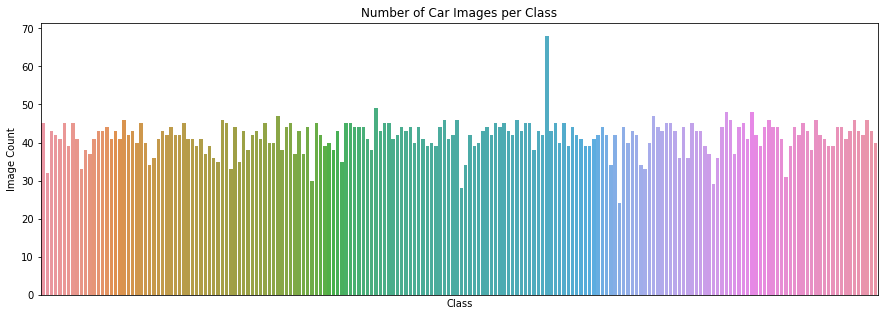

In [7]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(train_info.class_id)
plt.title("Number of Car Images per Class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks([])
plt.show()

In [8]:
# The function below returns an image and corresponding label at position i from train_info or public_test_info 
# dataframe for plotting.
# Arg(s):
#     df (pandas.core.frame.DataFrame): train_info or public_test_info dataframe
#     i (int): element i in the dataframe.
def get_image_info(df, i):
    # Get relevant informations from df.loc[i]
    x1 = df["bbox_x1"][i]
    y1 = df["bbox_y1"][i] 
    x2 = df["bbox_x2"][i] 
    y2 = df["bbox_y2"][i]
    image_path = df["fname"][i]
    title = df["class_names"][i] if (df is train_info) else "Unknown"
    
    # Load colour (BGR) image
    img = cv2.imread(str(image_path))
    
    # Add bounding box to the image
    cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), thickness=3)
    
    # Convert BRG image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return cv_rgb, title

# The function below returns an cropped image and corresponding label at position i from train_info 
# or public_test_info dataframe for plotting.
# Arg(s):
#     df (pandas.core.frame.DataFrame): train_info or public_test_info dataframe
#     i (int): element i in the dataframe.
def crop_car_bounding_box(df, i):
    # Get relevant informations from df.loc[i]
    x1 = df["bbox_x1"][i]
    y1 = df["bbox_y1"][i] 
    x2 = df["bbox_x2"][i] 
    y2 = df["bbox_y2"][i]
    image_path = df["fname"][i]
    title = df["class_names"][i] if (df is train_info) else "Unknown"
    
    # Load colour (BGR) image
    img = cv2.imread(str(image_path))
    crop_img = img[y1:y2,x1:x2]
    
    # Convert BRG image to RGB for plotting
    cv_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
    
    return cv_rgb, title

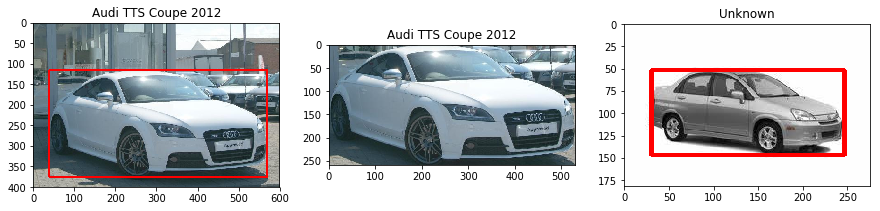

In [9]:
# Draw first image from training set and public test set
fig, ax = plt.subplots(1, 3, figsize=(15,15))
# Draw image from training set
cv_rgb, title = get_image_info(train_info, 0)
ax[0].imshow(cv_rgb)
ax[0].set_title(title)

# Crop car from first image in the training set
cv_rgb, title = crop_car_bounding_box(train_info, 0)
ax[1].imshow(cv_rgb)
ax[1].set_title(title)

# Draw image from test set
cv_rgb, title = get_image_info(public_test_info, 0)
ax[2].imshow(cv_rgb)
ax[2].set_title(title)

plt.show()

In [10]:
IMG_HEIGHT, IMG_WIDTH = 299, 299 # For Xception model

# Keras CNN requires a 4D array as input with shape (batch, rows, cols, channels)
# The function below takes a list of string-valued file paths to colour images and return a 4D tensor for Keras CNN
# Arg(s):
#     image_paths: string-valued file paths to colour images
def prepare_tensors_crop_bounding_box(df):
    tensors = []
    for _, index in enumerate(tqdm(df.index)):
        # Get relevant informations from df.loc[i]
        x1 = df.loc[index][0]
        y1 = df.loc[index][1]
        x2 = df.loc[index][2]
        y2 = df.loc[index][3]
        image_path = df.loc[index][4]

        # Load RGB image as PIL.Image.Image type        
        img = image.load_img(image_path)
        
        # Crop bounding box, and resize image to target size
        img = img.resize(size=(IMG_WIDTH, IMG_HEIGHT), resample=Image.LANCZOS, box=(x1,y1,x2,y2))
        
        # Convert PIL.Image.Image type to 3D tensor with shape TARGET_SIZE
        # Rescale the RGB coefficients from range (0, 255) to range (0,1)
        x = image.img_to_array(img)/255.0
        
        # Convert 3D tensor to 4D tensor
        tensors.append(np.expand_dims(x, axis=0))
    return np.vstack(tensors)

### Prepare Training, Validation, Test Sets from cropped images

In [11]:
X, y = train_info.drop(columns=["class_id", "class_names"]), train_info["class_id"]

# Stratify parameter is set to ensure that the train and test sets have approximately the same percentage of 
# samples of each target class as the complete set.
# Split training set into training, validation, and test sets (80%, 10%, 10% respectively)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=np.array(y), 
                                                    random_state=40)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, 
                                                      stratify=np.array(y_test), 
                                                      random_state=40)

# One-hot encoding the classes
N_CLASSES = cars_info.size # 196 classes of cars
y_train_ohe = np_utils.to_categorical(y_train, N_CLASSES)
y_test_ohe = np_utils.to_categorical(y_test, N_CLASSES)
y_valid_ohe = np_utils.to_categorical(y_valid, N_CLASSES)

In [12]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_tensors = prepare_tensors_crop_bounding_box(X_train).astype("float32")
valid_tensors = prepare_tensors_crop_bounding_box(X_valid).astype("float32")
test_tensors = prepare_tensors_crop_bounding_box(X_test).astype("float32")

print(train_tensors.shape[0], "training samples")
print(valid_tensors.shape[0], "validation samples")
print(test_tensors.shape[0], "test samples")

100%|██████████| 814/814 [00:31<00:00, 31.29it/s]


6515 training samples
815 validation samples
814 test samples


### Initialise Tensorflow Session

In [13]:
tf.keras.backend.clear_session()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
tf.keras.backend.set_session(sess)

### Image Augmentation

In [14]:
# Data Generator for Training and Validation
augmentation_datagen = ImageDataGenerator(
    shear_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

# Data Generator for Testing
non_augmentation_datagen = ImageDataGenerator()

In [15]:
BATCH_SIZE = 32

# Run Training images through the model
train_generator = augmentation_datagen.flow(train_tensors, y_train_ohe, shuffle=False, batch_size=BATCH_SIZE)
train_steps = int(math.ceil(train_tensors.shape[0]/float(BATCH_SIZE)))

# Run Validation images through the model
valid_generator = augmentation_datagen.flow(valid_tensors, y_valid_ohe, shuffle=False, batch_size=BATCH_SIZE)
valid_steps = int(math.ceil(valid_tensors.shape[0]/float(BATCH_SIZE)))

### Benchmarking Model

In [16]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding="same", activation="relu", input_shape=train_tensors[0].shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=2, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES, activation="softmax"))

model.summary()

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 149, 149, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)  

In [17]:
EPOCHS = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath="benchmark.weights.best.hdf5", 
                               monitor="val_loss", 
                               save_best_only=True, 
                               verbose=1)

benchmark = model.fit_generator(train_generator,
                    steps_per_epoch=train_steps,
                    epochs=EPOCHS, verbose=1, callbacks=[checkpointer],
                    validation_data=valid_generator,
                    validation_steps=valid_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
26/26 [==============================] - 12s 469ms/step - loss: 5.2088 - acc: 0.0123

Epoch 00001: val_loss improved from inf to 5.20883, saving model to benchmark.weights.best.hdf5
204/204 [==============================] - 108s 528ms/step - loss: 5.6021 - acc: 0.0077 - val_loss: 5.2088 - val_acc: 0.0123
Epoch 2/5
26/26 [==============================] - 12s 464ms/step - loss: 5.1404 - acc: 0.0147

Epoch 00002: val_loss improved from 5.20883 to 5.14040, saving model to benchmark.weights.best.hdf5
204/204 [==============================] - 104s 509ms/step - loss: 5.1637 - acc: 0.0143 - val_loss: 5.1404 - val_acc: 0.0147
Epoch 3/5
26/26 [==============================] - 12s 465ms/step - loss: 5.1076 - acc: 0.0172

Epoch 00003: val_loss improved from 5.14040 to 5.10758, saving model to benchmark.weights.best.hdf5
204/204 [==============================] - 103s 506ms/step - loss: 5.1088 - acc: 0.0160 - val_loss: 5.1076 - val_acc: 

### Test Benchmarking Model Against Public Test Set

In [18]:
# Load the weights that yielded the best validation accuracy
model.load_weights("benchmark.weights.best.hdf5")

# Evaluate and print test accuracy
score = model.evaluate(test_tensors, y_test_ohe, verbose=0)
print("Test accuracy:", score[1])

Test accuracy: 0.01965602


### Fine-tune Xception Model

In [13]:
# Xception
Xception_model = Xception(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
for i, layer in enumerate(Xception_model.layers):
    if i < 94: layer.trainable = False
    else: layer.trainable = True

model = Sequential()
model.add(Xception_model)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(rate=0.5))
model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(rate=0.5))
model.add(Dense(N_CLASSES, activation="softmax"))

# Set optimizer
optimizer = SGD(lr=1e-2, momentum=0.9, decay=1e-6)

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
EPOCHS = 70
ES_PATIENCE = 10 # EarlyStopping patience value
RLROP_PATIENCE = 3 # ReduceLROnPlateau patience value
RLROP_FACTOR = 0.2 # ReduceLROnPlateau factor value

callbacks = [ModelCheckpoint(filepath="grabai_cars.Xception_FT.weights.best.hdf5", 
                             monitor="val_loss", 
                             save_best_only=True, 
                             verbose=1),
             EarlyStopping(monitor="val_acc", 
                           patience=ES_PATIENCE, 
                           min_delta=1e-3, 
                           restore_best_weights=True,
                           verbose=1),
             ReduceLROnPlateau(monitor="val_loss", 
                               patience=RLROP_PATIENCE, 
                               factor=RLROP_FACTOR, 
                               verbose=1)
            ]

# Train the model
history = model.fit_generator(train_generator,
                    steps_per_epoch=train_steps,
                    epochs=EPOCHS, verbose=1, callbacks=callbacks,
                    validation_data=valid_generator,
                    validation_steps=valid_steps)

Epoch 1/70
26/26 [==============================] - 12s 466ms/step - loss: 10.4775 - acc: 0.0209

Epoch 00001: val_loss improved from inf to 10.47754, saving model to grabai_cars.Xception_FT.weights.best.hdf5
204/204 [==============================] - 108s 529ms/step - loss: 13.4709 - acc: 0.0071 - val_loss: 10.4775 - val_acc: 0.0209
Epoch 2/70
26/26 [==============================] - 12s 467ms/step - loss: 7.1769 - acc: 0.0417

Epoch 00002: val_loss improved from 10.47754 to 7.17686, saving model to grabai_cars.Xception_FT.weights.best.hdf5
204/204 [==============================] - 105s 513ms/step - loss: 8.6845 - acc: 0.0206 - val_loss: 7.1769 - val_acc: 0.0417
Epoch 3/70
26/26 [==============================] - 13s 492ms/step - loss: 5.3467 - acc: 0.0847

Epoch 00003: val_loss improved from 7.17686 to 5.34667, saving model to grabai_cars.Xception_FT.weights.best.hdf5
204/204 [==============================] - 104s 511ms/step - loss: 6.2967 - acc: 0.0430 - val_loss: 5.3467 - val_acc

Epoch 27/70
26/26 [==============================] - 12s 465ms/step - loss: 1.9950 - acc: 0.6258

Epoch 00027: val_loss improved from 2.02745 to 1.99499, saving model to grabai_cars.Xception_FT.weights.best.hdf5
204/204 [==============================] - 103s 505ms/step - loss: 1.0543 - acc: 0.8612 - val_loss: 1.9950 - val_acc: 0.6258
Epoch 28/70
26/26 [==============================] - 14s 537ms/step - loss: 1.8563 - acc: 0.6282

Epoch 00028: val_loss improved from 1.99499 to 1.85629, saving model to grabai_cars.Xception_FT.weights.best.hdf5
204/204 [==============================] - 106s 519ms/step - loss: 0.9172 - acc: 0.8938 - val_loss: 1.8563 - val_acc: 0.6282
Epoch 29/70
26/26 [==============================] - 12s 467ms/step - loss: 1.7931 - acc: 0.6491

Epoch 00029: val_loss improved from 1.85629 to 1.79308, saving model to grabai_cars.Xception_FT.weights.best.hdf5
204/204 [==============================] - 101s 495ms/step - loss: 0.8640 - acc: 0.9041 - val_loss: 1.7931 - val_a

### Test Model against Public Test Set

In [24]:
# Load the weights that yielded the best validation accuracy
model.load_weights("grabai_cars.Xception_FT.weights.best.hdf5")

# Evaluate and print test accuracy
score = model.evaluate(test_tensors, y_test_ohe, verbose=0)
print("Test accuracy:", score[1])

Test accuracy: 0.7076167


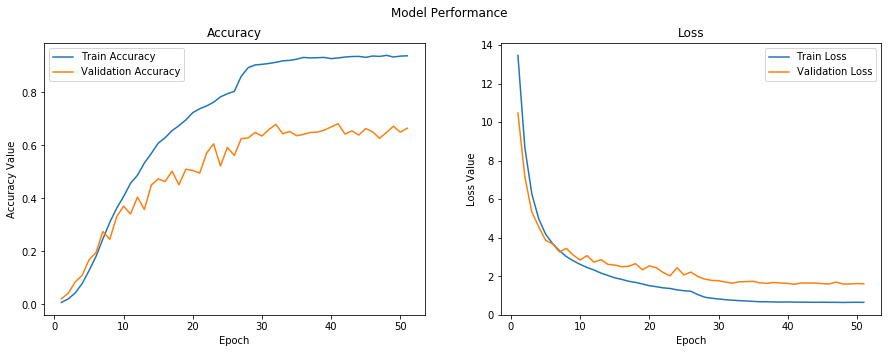

In [26]:
# Model evaluation
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle("Model Performance", fontsize=12)
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1,len(acc)+1)
ax1.plot(epochs, acc, label="Train Accuracy")
ax1.plot(epochs, val_acc, label="Validation Accuracy")
ax1.set_ylabel("Accuracy Value")
ax1.set_xlabel("Epoch")
ax1.set_title("Accuracy")
l1 = ax1.legend(loc="best")

ax2.plot(epochs, loss, label="Train Loss")
ax2.plot(epochs, val_loss, label="Validation Loss")
ax2.set_ylabel("Loss Value")
ax2.set_xlabel("Epoch")
ax2.set_title("Loss")
l2 = ax2.legend(loc="best")

### Test Model against Public Test Set

In [14]:
X_public_test = public_test_info.drop(columns=["class_id", "class_names"])
y_public_test = public_test_info["class_id"]

y_public_test_ohe = np_utils.to_categorical(y_public_test, N_CLASSES)

ImageFile.LOAD_TRUNCATED_IMAGES = True

public_test_tensors = prepare_tensors_crop_bounding_box(X_public_test).astype("float32")

100%|██████████| 8041/8041 [02:44<00:00, 48.88it/s]


In [16]:
# Load the weights that yielded the best validation accuracy
model.load_weights("grabai_cars.Xception_FT.weights.best.hdf5")

# Evaluate and print public test accuracy
score = model.evaluate(public_test_tensors, y_public_test_ohe, verbose=0)
print("Test accuracy:", score[1])

Test accuracy: 0.7260291


### Reference:
- [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/abs/1610.02357)